#### Instructions:  
1. Libraries allowed: **Python basic libraries, numpy, pandas, scikit-learn (only for data processing), pytorch, and ClearML.**
2. Show all outputs.
3. Submit jupyter notebook and a pdf export of the notebook. Check canvas for detail instructions for the report.
4. Below are the questions/steps that you need to answer. Add as many cells as needed.

## Step 1: Data Processing
1. Partition your dataset into training and test if they are not already. You can do it manually by creating separate folders for training and test.
2. Estimate mean and variance from the training data for normalization.
3. Create "transforms" for training and test for normalization and data augmentation.
4. Create custom dataset or instantiate built-in "ImageFolder" with the transforms for both training and test.
5. Partition the training dataset further into training and validation
6. Use dataloder to partition and generate minibatches.
7. Visualize input and output for two sample images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cuda
Estimated mean: tensor([0.5403, 0.5394, 0.5474])
Estimated std: tensor([0.2507, 0.2491, 0.2505])


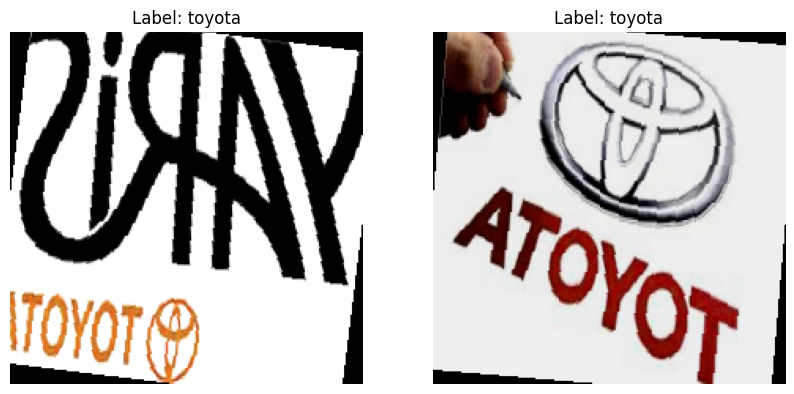

In [ ]:
# code
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths to image directories
train_dir = "/content/drive/MyDrive/Car_Brand_Logos/Train"
test_dir = "/content/drive/MyDrive/Car_Brand_Logos/Test"


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Estimate mean and variance from the training data
temp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
temp_dataset = ImageFolder(train_dir, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)

# Calculate mean and std over the entire training dataset
mean = 0.0
std = 0.0
num_samples = 0

for images, _ in temp_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print(f"Estimated mean: {mean}")
print(f"Estimated std: {std}")

#  Create transforms for training and test with normalization and augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create custom dataset or instantiate ImageFolder with transforms
train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

# Partition the training dataset further into training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

#  Use DataLoader to partition and generate minibatches
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#  Visualize input and output for two sample images
data_iter = iter(train_loader)
images, labels = next(data_iter)

images, labels = images.to(device), labels.to(device)

# Function to denormalize and display images
def denormalize(img, mean, std, device):
    mean = mean.to(device)
    std = std.to(device)
    img = img * std[:, None, None] + mean[:, None, None]
    return img.clamp(0, 1)

# Display two sample images with labels
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean = mean.to(device)
std = std.to(device)
images = images.to(device)

for i in range(2):
    img = images[i]
    label = labels[i]
    img = denormalize(img, mean, std, device)
    img = img.permute(1, 2, 0).cpu().numpy()
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {train_dataset.classes[label]}")
    axes[i].axis("off")

plt.show()



## Step 2: initial network
1. Create a convolutional neural network. Make the hyper-parameters that you want to tune (e.g., number of layers) dynamic so that you can change them without altering the code. You can choose additional hyperparameters but the followings must be considered.
   1. Number of filters
   2. Number of layers
   3. learning rate
   4. Optimization algorithm specific hyper-paramters, e.g., momentum, for SGD.
   5. weight decay.
3. Select two images. Pick a configuation of NN and hyperparamters and train to overfit the samples, i.e., the accuracy will be 100%. If the network does not overfit, try differnt hyperparamter configuration, e.g., number of paramters, learning rate.

Epoch [1/100], Loss: 0.7125, Accuracy: 0.0000
Epoch [2/100], Loss: 0.6360, Accuracy: 1.0000
Model has successfully overfitted!


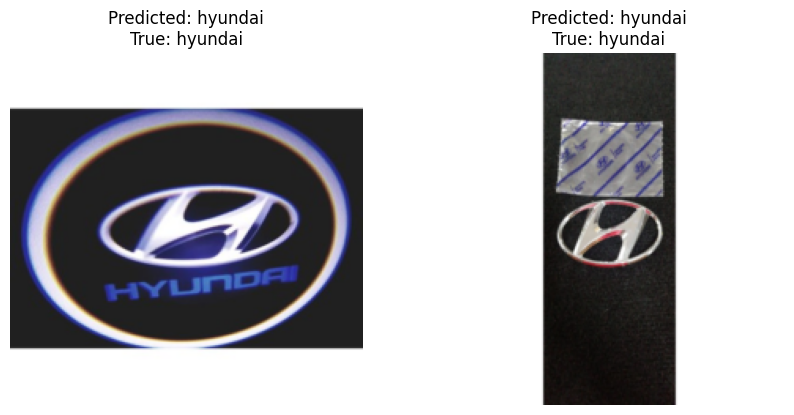

In [ ]:
# code
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
num_filters = 32
num_layers = 3
learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4

# Define the CNN
class DynamicCNN(nn.Module):
    def __init__(self, num_layers, num_filters):
        super(DynamicCNN, self).__init__()
        layers = []

        # Input convolutional layer
        layers.append(nn.Conv2d(3, num_filters, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Additional convolutional layers
        for _ in range(num_layers - 1):
            layers.append(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_layers = nn.Sequential(*layers)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_filters * (224 // (2 ** num_layers))**2, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

# Data Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset and select two images for overfitting
dataset = ImageFolder("/content/drive/MyDrive/Car_Brand_Logos/Train", transform=transform)
two_samples = [dataset[0], dataset[1]]  # Select first two samples
overfit_loader = DataLoader(two_samples, batch_size=2, shuffle=False)

# Initialize the network, loss function, and optimizer
model = DynamicCNN(num_layers=num_layers, num_filters=num_filters).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Training Loop for Overfitting
def train_to_overfit(model, loader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in loader:
            images, labels = images.to('cuda'), labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Check training accuracy
        _, preds = torch.max(outputs, 1)
        acc = (preds == labels).float().mean()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")

        # Stop training when accuracy reaches 100%
        if acc.item() == 1.0:
            print("Model has successfully overfitted!")
            break

# Train the model to overfit the two selected images
train_to_overfit(model, overfit_loader, criterion, optimizer, num_epochs=100)

# Visualize predictions
model.eval()
images, labels = next(iter(overfit_loader))
images, labels = images.to('cuda'), labels.to('cuda')

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Denormalize and plot images with predictions
def denormalize(img):
    return img.clamp(0, 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    img = images[i].cpu().permute(1, 2, 0)
    axes[i].imshow(denormalize(img))
    axes[i].set_title(f"Predicted: {dataset.classes[preds[i]]}\nTrue: {dataset.classes[labels[i]]}")
    axes[i].axis("off")
plt.show()


## Step 3: ClearML base task
Now train your network with ClearML by creating a task and connecting the parameters to the task. Copy the plots from ClearML and upload them here.

## BASE CODE WITHOUT LEARNING RATE DECAY

In [ ]:
# code
!pip install --quiet git+https://github.com/allegroai/clearml


In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=17JHOPLD9ZBMAU2TI2TFQ7RLG14FDN
%env CLEARML_API_SECRET_KEY=10CWh86rfjTDyv1nyN_G3FX6Z7okJ392eu47WTiMjWzDEGmrTOA1okhYdbiyNpfvmxk

In [ ]:
#BASE CODE without learning rate decay.

from clearml import Task, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
import shutil

# Initialize ClearML Task
task = Task.init(
    project_name="BASE222",
    task_name="BASE222",
    task_type="training"
)

# Load Dataset
dataset_id = "491bc626572847bd9d2c476f07b57ca7"
dataset = Dataset.get(dataset_id)
dataset_path = dataset.get_local_copy()

train_dir = os.path.join(dataset_path, "Train")
test_dir = os.path.join(dataset_path, "Test")

checkpoint_dir = os.path.join(train_dir, ".ipynb_checkpoints")
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

# Define Hyperparameters
hyperparams = {
    "General/num_layers": 2,
    "General/num_filters": 8,
    "SGD/learning_rate": 0.01,
    "SGD/momentum": 0.9,
    "General/weight_decay": 0.0005,
    "batch_size": 4,
    "epochs": 5
}
task.connect(hyperparams)

# Data Processing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the dataset
train_dataset = ImageFolder(train_dir, transform=transform)

# Use only 1000 samples
train_subset, _ = random_split(train_dataset, [1000, len(train_dataset) - 1000])
train_size = int(0.8 * len(train_subset))  # Split train_subset into 80% train, 20% validation
val_size = len(train_subset) - train_size
train_subset, val_subset = random_split(train_subset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=hyperparams["batch_size"], shuffle=True)
val_loader = DataLoader(val_subset, batch_size=hyperparams["batch_size"], shuffle=False)

# Create Model
class SimpleCNN(nn.Module):
    def __init__(self, num_layers, num_filters, num_classes):
        super(SimpleCNN, self).__init__()
        self.layers = nn.ModuleList()
        in_channels = 3
        for _ in range(num_layers):
            self.layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=3, stride=1, padding=1))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = num_filters
        self.fc = nn.Linear(num_filters * (224 // (2 ** num_layers)) ** 2, num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = SimpleCNN(num_layers=hyperparams["General/num_layers"],
                  num_filters=hyperparams["General/num_filters"],
                  num_classes=len(train_dataset.classes))

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=hyperparams["SGD/learning_rate"],
    momentum=hyperparams["SGD/momentum"],
    weight_decay=hyperparams["General/weight_decay"]
)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
model = model.to(device)

for epoch in range(hyperparams["epochs"]):
    train_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    task.get_logger().report_scalar("Validation", "Loss", iteration=epoch, value=train_loss)
    task.get_logger().report_scalar("Validation", "Accuracy", iteration=epoch, value=accuracy)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Save the Model
model_save_path = "trained_model.pth"
torch.save(model.state_dict(), model_save_path)
task.upload_artifact("model", artifact_object=model_save_path)
print(f"Model saved and uploaded as artifact: {model_save_path}")

# Close Task
task.close()

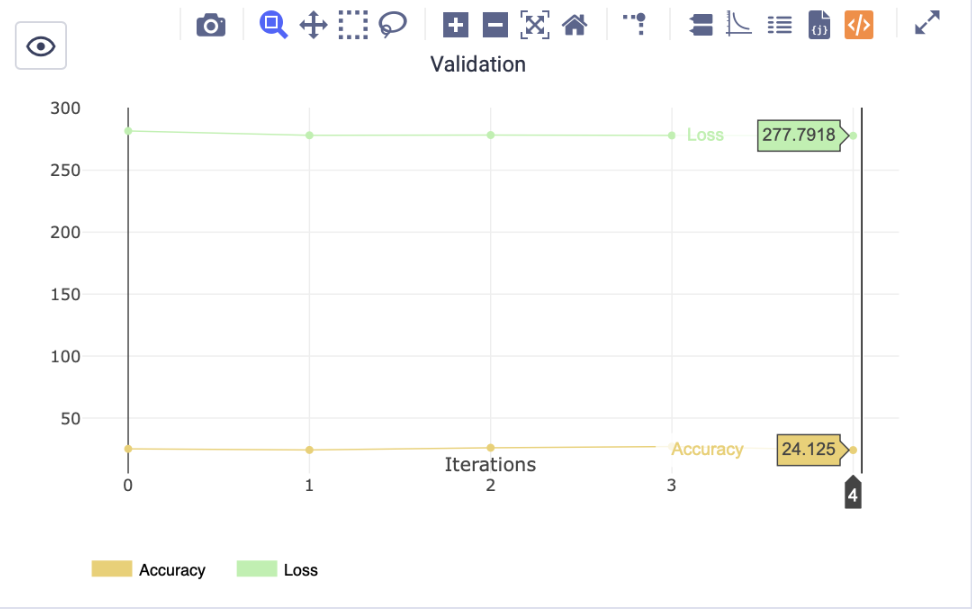

## BASE CODE WITH LEARNING RATE DECAY

In [ ]:
# #BASE CODE with learning rate decay.
from clearml import Task, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
import shutil

# Initialize ClearML Task
task = Task.init(
    project_name="00000",
    task_name="00000",
    task_type="training"
)

dataset_id = "491bc626572847bd9d2c476f07b57ca7"
dataset = Dataset.get(dataset_id)
dataset_path = dataset.get_local_copy()

train_dir = os.path.join(dataset_path, "Train")
test_dir = os.path.join(dataset_path, "Test")

checkpoint_dir = os.path.join(train_dir, ".ipynb_checkpoints")
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

# Hyperparameters
hyperparams = {
    "General/num_layers": 2,
    "General/num_filters": 8,
    "SGD/learning_rate": 0.01,
    "SGD/momentum": 0.9,
    "General/weight_decay": 0.0005,
    "SGD/learning_rate_decay": 0.95,
    "batch_size": 4,
    "epochs": 5
}
task.connect(hyperparams)

# Data Processing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the dataset
train_dataset = ImageFolder(train_dir, transform=transform)

# Use only 1000 samples
train_subset, _ = random_split(train_dataset, [1000, len(train_dataset) - 1000])
train_size = int(0.8 * len(train_subset))  # Split train_subset into 80% train, 20% validation
val_size = len(train_subset) - train_size
train_subset, val_subset = random_split(train_subset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=hyperparams["batch_size"], shuffle=True)
val_loader = DataLoader(val_subset, batch_size=hyperparams["batch_size"], shuffle=False)

# Create Model
class SimpleCNN(nn.Module):
    def __init__(self, num_layers, num_filters, num_classes):
        super(SimpleCNN, self).__init__()
        self.layers = nn.ModuleList()
        in_channels = 3
        for _ in range(num_layers):
            self.layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=3, stride=1, padding=1))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = num_filters
        self.fc = nn.Linear(num_filters * (224 // (2 ** num_layers)) ** 2, num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = SimpleCNN(num_layers=hyperparams["General/num_layers"],
                  num_filters=hyperparams["General/num_filters"],
                  num_classes=len(train_dataset.classes))

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=hyperparams["SGD/learning_rate"],
    momentum=hyperparams["SGD/momentum"],
    weight_decay=hyperparams["General/weight_decay"]
)
scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=hyperparams["SGD/learning_rate_decay"]
)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
model = model.to(device)

for epoch in range(hyperparams["epochs"]):
    train_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    task.get_logger().report_scalar("Validation", "Loss", iteration=epoch, value=train_loss)
    task.get_logger().report_scalar("Validation", "Accuracy", iteration=epoch, value=accuracy)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%")
    scheduler.step()

# Save the Model
model_save_path = "trained_model.pth"
torch.save(model.state_dict(), model_save_path)
task.upload_artifact("model", artifact_object=model_save_path)
print(f"Model saved and uploaded as artifact: {model_save_path}")

# Close Task
task.close()

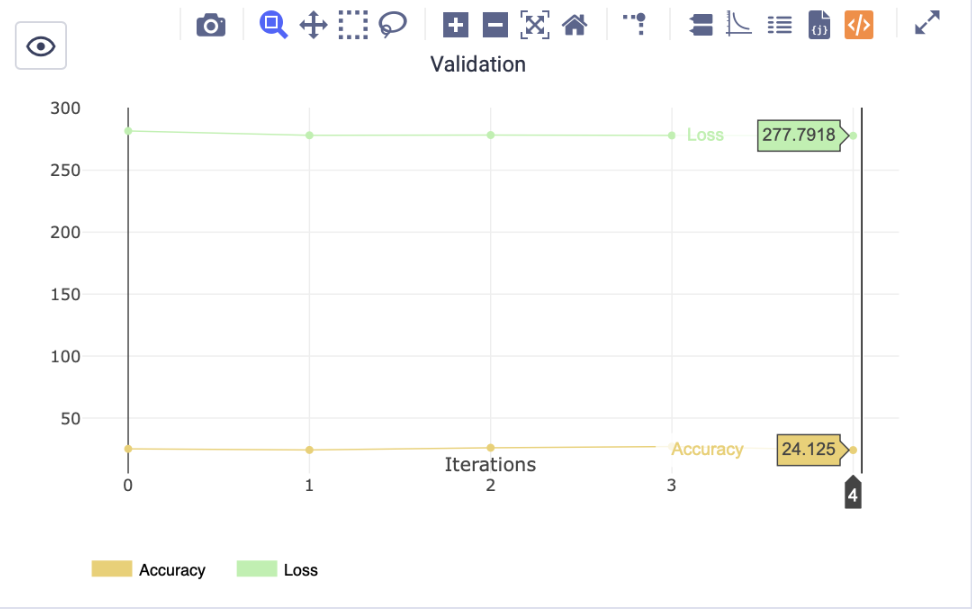